# IACT DL3 data with Gammapy

## Introduction

This tutorial will show you how to work with IACT (Imaging Atmospheric Cherenkov Telescope) DL3 ("data level 3").

We will work with event data and instrument response functions (IRFs), mainly using [gammapy.data](http://docs.gammapy.org/en/latest/data/index.html) and [gammapy.irf](http://docs.gammapy.org/en/latest/irf/index.html).

This notebook uses a preliminary small test dataset from the CTA first data challenge (1DC).

The main class to load data is

* [gammapy.data.DataStore](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStore.html)

The `DataStore` has two index tables:

* `DataStore.obs_table` ([gammapy.data.ObservationTable](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationTable.html)) to list and select available observations.
* `DataStore.hdu_table` ([gammapy.data.HDUIndexTable](http://docs.gammapy.org/en/latest/api/gammapy.data.HDUIndexTable.html)) to locate data for a given observation.

Data loading is done via the `DataStore.obs` method which returns a

* [gammapy.data.DataStoreObservation](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStoreObservation.html)

object, which on property access loads the data and IRFs and returns them as Gammapy objects.

We support the common IACT DL3 data formats: http://gamma-astro-data-formats.readthedocs.io/ .

In this tutorial we will use objects of these types:

* [gammapy.data.EventList](http://docs.gammapy.org/en/latest/api/gammapy.data.EventList.html)


* Load [gammapy.irf.EffectiveAreaTable2D](http://docs.gammapy.org/en/latest/api/gammapy.irf.EffectiveAreaTable2D.html), which has AEFF info for the whole field of view (FOV).
* For the given source offset in the FOV, slice out [gammapy.irf.EffectiveAreaTable](http://docs.gammapy.org/en/latest/api/gammapy.irf.EffectiveAreaTable.html)


* Load [gammapy.irf.EnergyDispersion2D](http://docs.gammapy.org/en/latest/api/gammapy.irf.EnergyDispersion2D.html), which has EDISP info for the whole FOV.
* For a given source offset in the FOV, slice out [gammapy.irf.EnergyDispersion](http://docs.gammapy.org/en/latest/api/gammapy.irf.EnergyDispersion.html)


* Load [gammapy.irf.EnergyDependentMultiGaussPSF](http://docs.gammapy.org/en/latest/api/gammapy.irf.EnergyDependentMultiGaussPSF.html), which has PSF info for the whole FOV using an analytical PSF model.
* For a given source offset in the FOV, slice out [gammapy.irf.EnergyDependentTablePSF](http://docs.gammapy.org/en/latest/api/gammapy.irf.EnergyDependentTablePSF.html).
* For a given energy or energy band, compute [gammapy.irf.TablePSF](http://docs.gammapy.org/en/latest/api/gammapy.irf.TablePSF.html).




## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import matplotlib
print('numpy : {}'.format(np.__version__))
print('matplotlib : {}'.format(matplotlib.__version__))

numpy : 1.12.1
matplotlib : 2.0.2


In [3]:
# We only need to import the `DataStore`,
# all other data objects can be loaded via the data store.
from gammapy.data import DataStore
import astropy.units as u

## Data store

First, we need to select some observations for our spectral analysis. To this end we use the [data management](http://docs.gammapy.org/en/latest/data/dm.html) functionality in gammapy. The following example uses a simulated crab dataset in [gammapy-extra](https://github.com/gammapy/gammapy-extra). Ideally, we'd use crabs runs from the H.E.S.S. public data release, so if you have the released files just change the ``DATA_DIR`` variable to the corresponding folder.

In [4]:
# data_store = DataStore.from_dir('$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2/')
data_store = DataStore.from_dir('$GAMMAPY_EXTRA/test_datasets/cta_1dc')

In [5]:
data_store.info()


Data store summary info:
name: noname

HDU index table:
BASE_DIR: /Users/jer/git/gammapy-extra/test_datasets/cta_1dc
Rows: 10038
OBS_ID: 1 -- 1673
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']

Observation table:
Number of observations: 1673


In [6]:
print(data_store.hdu_table.colnames)
data_store.hdu_table

['OBS_ID', 'HDU_TYPE', 'HDU_CLASS', 'FILE_DIR', 'FILE_NAME', 'HDU_NAME']


OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME
int64,str6,str10,str39,str26,str21
1,events,events,data/baseline/gc,gc_baseline_000001.fits.gz,EVENTS
1,gti,gti,data/baseline/gc,gc_baseline_000001.fits.gz,EVENTS
1,aeff,aeff_2d,caldb/data/cta/prod3b/bcf/South_z20_50h,irf_file.fits,EFFECTIVE AREA
1,edisp,edisp_2d,caldb/data/cta/prod3b/bcf/South_z20_50h,irf_file.fits,ENERGY DISPERSION
1,psf,psf_3gauss,caldb/data/cta/prod3b/bcf/South_z20_50h,irf_file.fits,POINT SPREAD FUNCTION
1,bkg,bkg_3d,caldb/data/cta/prod3b/bcf/South_z20_50h,irf_file.fits,BACKGROUND
2,events,events,data/baseline/gc,gc_baseline_000002.fits.gz,EVENTS
2,gti,gti,data/baseline/gc,gc_baseline_000002.fits.gz,EVENTS
2,aeff,aeff_2d,caldb/data/cta/prod3b/bcf/South_z20_50h,irf_file.fits,EFFECTIVE AREA


## Observation selection

Select observations using the observation table

In [12]:
table = data_store.obs_table
print(table.colnames)

subtable = table[
    (np.abs(table['GLAT_PNT']) < 0.2) &
    (table['LIVETIME'] > 1500)
]
print("Found {} runs".format(len(subtable)))
#subtable[::25][['OBS_ID', 'GLON_PNT', 'GLAT_PNT', 'LIVETIME']]
subtable[::25]


['OBS_ID', 'RA_PNT', 'DEC_PNT', 'GLON_PNT', 'GLAT_PNT', 'ZEN_PNT', 'ALT_PNT', 'AZ_PNT', 'ONTIME', 'LIVETIME', 'DEADC', 'TSTART', 'TSTOP', 'DATE_OBS', 'TIME_OBS', 'DATE_END', 'TIME_END', 'EVENTS_FILENAME', 'EVENT_COUNT', 'EVENT_TIME_MIN', 'EVENT_TIME_MAX', 'EVENT_ENERGY_MIN', 'EVENT_ENERGY_MAX']
Found 385 runs


OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE_OBS,TIME_OBS,DATE_END,TIME_END,EVENTS_FILENAME,EVENT_COUNT,EVENT_TIME_MIN,EVENT_TIME_MAX,EVENT_ENERGY_MIN,EVENT_ENERGY_MAX
int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,str10,str8,str10,str8,str43,int64,float64,float64,float32,float32
309,266.26919556,-29.4497,359.500018539,-0.166664271339,0.0,90.0,0,1800.0,1710.0,0.94999998808,664164480.0,664166272.0,2021-01-17,14:06:51,2021-01-17,14:36:51,data/baseline/gc/gc_baseline_000309.fits.gz,139254,664164480.014,664166279.986,0.0300003,110.939
334,266.4486084,-29.1937,359.800028762,-0.166682286733,0.0,90.0,0,1800.0,1710.0,0.94999998808,664262400.0,664264192.0,2021-01-18,17:18:51,2021-01-18,17:48:51,data/baseline/gc/gc_baseline_000334.fits.gz,139819,664262400.002,664264199.979,0.0300011,114.658
359,266.68640137,-28.852,0.20002360719,-0.166673969835,0.0,90.0,0,1800.0,1710.0,0.94999998808,664360320.0,664362112.0,2021-01-19,20:30:51,2021-01-19,21:00:51,data/baseline/gc/gc_baseline_000359.fits.gz,139955,664360320.002,664362119.996,0.0300006,119.761
384,266.8637085,-28.5955,0.499973181372,-0.16667702663,0.0,90.0,0,1800.0,1710.0,0.94999998808,664508160.0,664509952.0,2021-01-21,13:34:51,2021-01-21,14:04:51,data/baseline/gc/gc_baseline_000384.fits.gz,140201,664508160.022,664509959.99,0.0300001,119.599
409,266.39700317,-29.1076,359.85004914,-0.0833612254625,0.0,90.0,0,1800.0,1710.0,0.94999998808,664606080.0,664607872.0,2021-01-22,16:46:51,2021-01-22,17:16:51,data/baseline/gc/gc_baseline_000409.fits.gz,139729,664606080.004,664607879.999,0.0300001,116.352
434,266.57540894,-28.8515,0.149956722272,-0.0833412686425,0.0,90.0,0,1800.0,1710.0,0.94999998808,664704000.0,664705792.0,2021-01-23,19:58:51,2021-01-23,20:28:51,data/baseline/gc/gc_baseline_000434.fits.gz,140056,664704000.013,664705799.991,0.0300001,117.138
459,266.81201172,-28.5095,0.550020459909,-0.083290609971,0.0,90.0,0,1800.0,1710.0,0.94999998808,664851840.0,664853632.0,2021-01-25,13:02:51,2021-01-25,13:32:51,data/baseline/gc/gc_baseline_000459.fits.gz,140656,664851840.0,664853639.978,0.0300001,118.366
484,266.28570557,-29.1068,359.800021175,2.84643806085e-05,0.0,90.0,0,1800.0,1710.0,0.94999998808,664949760.0,664951552.0,2021-01-26,16:14:51,2021-01-26,16:44:51,data/baseline/gc/gc_baseline_000484.fits.gz,140509,664949760.009,664951559.999,0.0300001,117.502
509,266.46450806,-28.8508,0.10002443619,-1.92849400882e-05,0.0,90.0,0,1800.0,1710.0,0.94999998808,665047680.0,665049472.0,2021-01-27,19:26:51,2021-01-27,19:56:51,data/baseline/gc/gc_baseline_000509.fits.gz,140139,665047680.002,665049479.996,0.0300002,119.878


In [24]:
# In the following examples we'll just use this one observation
obs = data_store.obs(obs_id=659)
print(obs)

Info for OBS_ID = 659
- Start time: 665735040.00
- Pointing pos: RA 266.30 deg / Dec -28.76 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 5.000 %



## Events

Explore the `EventList`

EVENT_ID,TIME,RA,DEC,ENERGY,DETX,DETY
,s,deg,deg,TeV,deg,deg
uint32,float64,float32,float32,float32,float32,float32
1,665735041.7,-92.6261,-28.4639,0.0384564,0.295805,0.942165
2,665735042.72,-92.307,-27.1749,0.0407098,1.58188,1.23743
3,665735042.878,-93.4977,-28.7857,0.0429804,-0.0219848,0.175349
4,665735045.849,-92.9102,-27.9038,0.0411471,0.857811,0.696059
5,665735057.423,-94.1769,-29.147,0.0347661,-0.383932,-0.418479
6,665735060.101,-93.8886,-28.8776,0.0560572,-0.113796,-0.167112
7,665735061.383,-93.293,-28.7534,0.0485764,0.0099285,0.354904
8,665735063.102,-92.7399,-27.9372,0.0365822,0.823348,0.846271


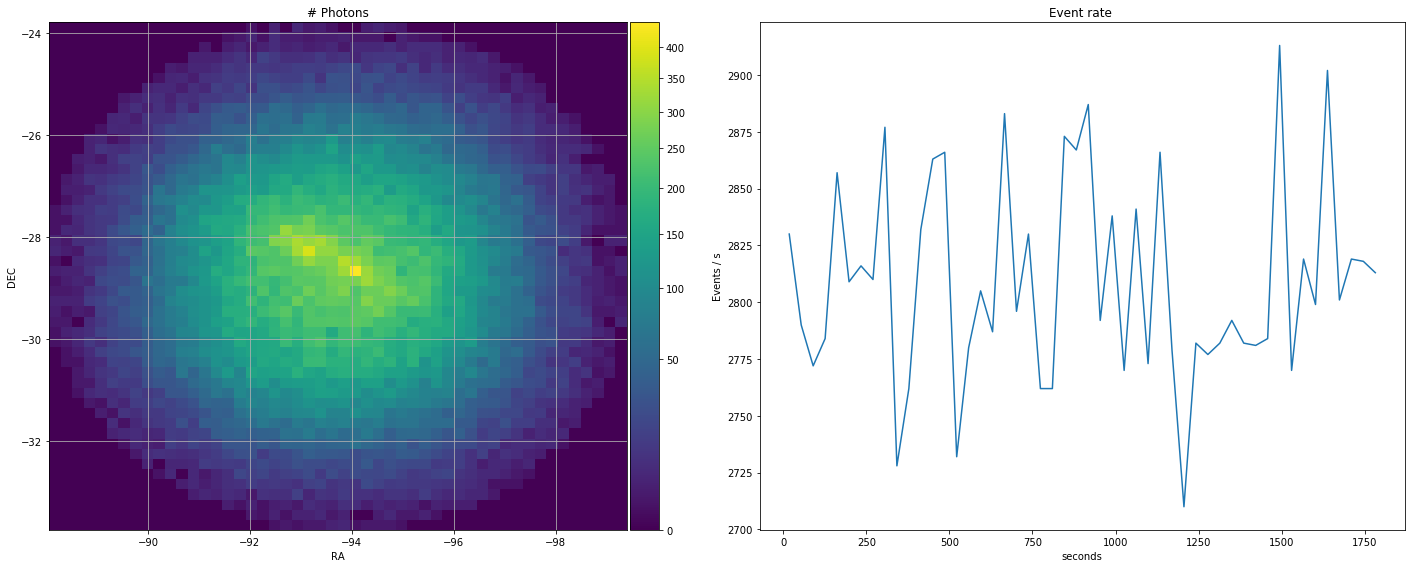

In [25]:
events = obs.events
events.peek()
#events.table[:][['EVENT_ID', 'TIME', 'ENERGY', 'RA', 'DEC']]
events.table[:]


## Effective area

Explore `EffectiveAreaTable2d` and `EffectiveAreaTable`

EffectiveAreaTable2D
NDDataArray summary info
energy         : size =    21, min =  0.016 TeV, max = 158.489 TeV
offset         : size =     6, min =  0.500 deg, max =  5.500 deg
Data           : size =   126, min =  0.000 m2, max = 4263992.500 m2



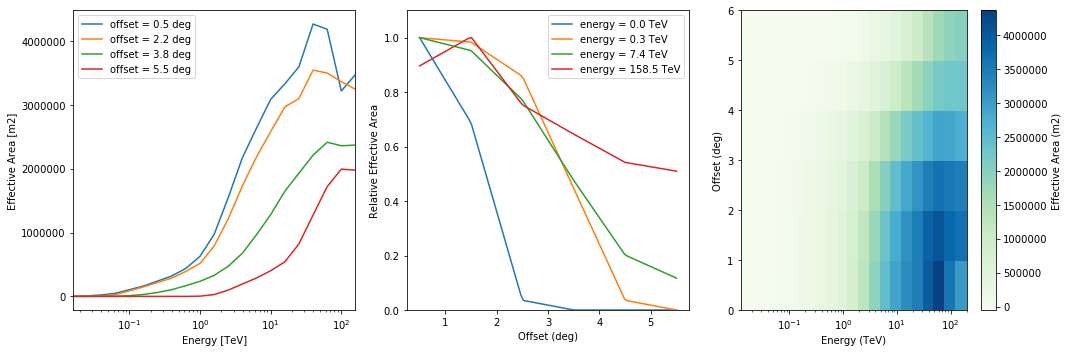

In [26]:
aeff = obs.aeff
aeff.peek()
print(aeff)

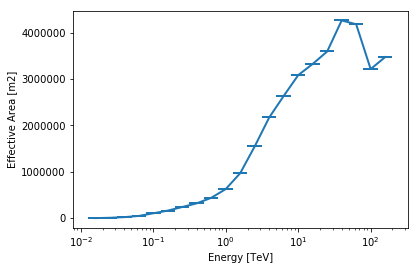

In [27]:
# Slice out effective area at a given offset
effarea = aeff.to_effective_area_table(offset=0.5 * u.deg)
effarea.plot()

## Energy dispersion

Explore `EnergyDispersion2d` and `EnergyDispersion`

/Users/jer/anaconda/envs/gammapy-dev/lib/python3.6/site-packages/matplotlib/colors.py:1154: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/Users/jer/anaconda/envs/gammapy-dev/lib/python3.6/site-packages/astropy/units/quantity.py:957: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)


EnergyDispersion2D
NDDataArray summary info
e_true         : size =    60, min =  0.011 TeV, max = 8912.510 TeV
migra          : size =   300, min =  0.005, max =  2.995
offset         : size =     6, min =  0.500 deg, max =  5.500 deg
Data           : size = 108000, min =  0.000, max = 913.000



/Users/jer/anaconda/envs/gammapy-dev/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


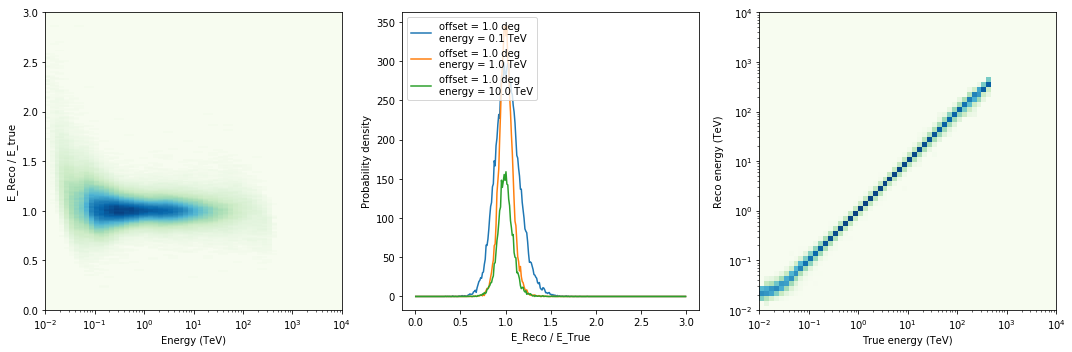

In [28]:
edisp = obs.edisp
edisp.peek()
print(edisp)

/Users/jer/anaconda/envs/gammapy-dev/lib/python3.6/site-packages/astropy/units/quantity.py:957: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)


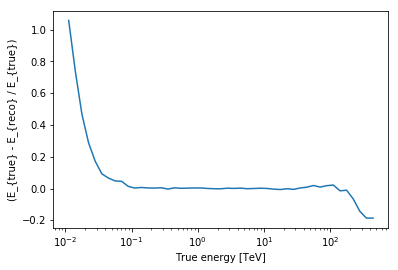

In [29]:
# Calculate energy dispersion matrix at a given offset
response_matrix = edisp.to_energy_dispersion(offset=0.5 * u.deg)
response_matrix.plot_bias()

## PSF

TODO: examples for point spread function (PSF)

/Users/jer/anaconda/envs/gammapy-dev/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


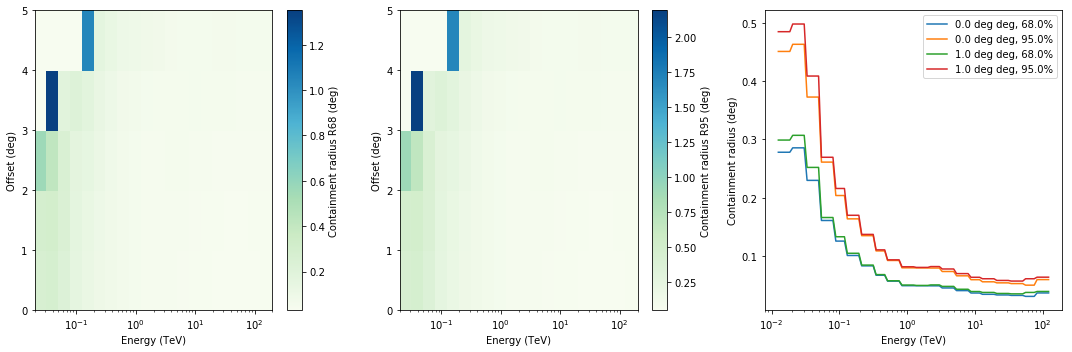

In [30]:
psf = obs.psf
psf.peek()
print(psf)

## Background model

TODO: example how to load and plot `gammapy.background.FOVBackgroundModel`

In [33]:
# TODO: doesn't work yet
# bkg = obs.bkg
# bkg.peek()
# print(bkg)

## Exercises

- TODO

In [16]:
# Start the exercises here!

## What next?

In this tutorial we have learned how to access and check IACT DL3 data.

Usually for a science analysis, if others have checked the data and IRF quality for you and you trust it's good, you don't need to do that.
Instead, you'll just run an analysis and look at higher-level results, like images or spectra.

Next you could do:
* image analysis
* spectral analysis
* cube analysis
* time analysis
* source detection